# Barrio Tortuga

#### Toy model of a neighborhood. 

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14
import os
import sys
import glob
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())
import numpy as np
import pandas as pd
import matplotlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Last updated on  Sat Apr 18 13:23:52 2020


In [6]:
fontsize=20
font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': fontsize,
        }

plt.rcParams["font.size"     ] = fontsize


In [7]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from mesa.visualization.TextVisualization import TextVisualization, TextGrid

# Grid properties


- Grid cells are indexed by [x][y], where [0][0] is assumed to be the bottom-left and [width-1][height-1] is the top-right. If a grid is
toroidal, the top and bottom, and left and right, edges wrap to each other

- Properties:
        - width, height: The grid's width and height.
        - torus: Boolean which determines whether to treat the grid as a torus.
        - grid: Internal list-of-lists which holds the grid cells themselves.

- Methods:
        - get_neighbors: Returns the objects surrounding a given cell.
        - get_neighborhood: Returns the cells surrounding a given cell.
        - get_cell_list_contents: Returns the contents of a list of cells
            ((x,y) tuples)
        - neighbor_iter: Iterates over position neightbors.
        - coord_iter: Returns coordinates as well as cell contents.
        - place_agent: Positions an agent on the grid, and set its pos variable.
        - move_agent: Moves an agent from its current position to a new position.
        - iter_neighborhood: Returns an iterator over cell coordinates that are in the neighborhood of a certain point.
        - torus_adj: Converts coordinate, handles torus looping.
        - out_of_bounds: Determines whether position is off the grid, returns the out of bounds coordinate.
        - iter_cell_list_contents: Returns an iterator of the contents of the cells identified in cell_list.
        - get_cell_list_contents: Returns a list of the contents of the cells identified in cell_list.
        - remove_agent: Removes an agent from the grid.
        - is_cell_empty: Returns a bool of the contents of a cell.


# Random Walker
- We start by implementing a random walker. This is an agente that moves at random in the grid. The idea is that sheep and wolves can inherit from it.

In [8]:
class WalkingAgent(Agent):
    '''
    Class implementing a turtle that can move at random

    Not indended to be used on its own, but to inherit its methods to multiple
    other agents.

    '''

    def __init__(self, unique_id, pos, model, moore=True):
        '''
        grid: The MultiGrid object in which the agent lives.
        x: The agent's current x coordinate
        y: The agent's current y coordinate
        moore: If True, may move in all 8 directions.
                Otherwise, only up, down, left, right.
        '''
        super().__init__(unique_id, model)
        self.pos = pos
        self.moore = moore

    def random_move(self):
        '''
        Step one cell in any allowable direction. 
        We use grid’s built-in get_neighborhood method, which returns all the neighbors of a given cell. 
        This method can get two types of cell neighborhoods: Moore (including diagonals), 
        and Von Neumann (only up/down/left/right). 
        It also needs an argument as to whether to include the center cell itself as one of the neighbors.
        '''
        # Pick the next cell from the adjacent cells.
        next_moves = self.model.grid.get_neighborhood(self.pos, self.moore, True)
        next_move = self.random.choice(next_moves)
        # Now move:
        self.model.grid.move_agent(self, next_move)

## Define a simple turtle moving at random

In [9]:
class RandomTurtle(WalkingAgent):
    '''
    Agent which only walks around.
    '''

    def step(self):
        self.random_move()



# Define Barrio tortuga

In [10]:
def number_of_turtles_in_cell(model):
    for y in range(model.grid.height):
        for x in range(model.grid.width):
            nc = 0
            c = model.grid.get_cell_list_contents((x,y))
            nc += len(c)

    #print(f'step {model.step}, nc = {nc}')
    return nc

def number_of_turtles_in_neighborhood(model):
    for y in range(model.grid.height):
        for x in range(model.grid.width):
            c = model.grid.get_cell_list_contents((x,y))
            if len(c) > 0:
                n_xy = model.grid.get_neighborhood((x,y), model.moore, False) #coordinates of neighbors
                nc = 0
                for xy in n_xy:
                    c = model.grid.get_cell_list_contents((xy[0], xy[1]))
                    nc += len(c)

    #print(f'step {model.step}, nc = {nc}')
    return nc

class BarrioTortuga(Model):
    '''
    A neighborhood where people goes out of their homes, walk around at random and meet other people.  
    '''

    def __init__(self, height, width, agent_count, moore=True):
        '''
        Create a new Barrio Tortuga

        Args:
            height, width: World size.
            agent_count: How many agents to create.
        '''


        self.height       = height
        self.width        = width
        self.grid         = MultiGrid(self.height, self.width, torus=True)
        self.agent_count  = agent_count
        self.schedule     = RandomActivation(self)
        self.moore        = moore
        self.datacollector = DataCollector(
        model_reporters={"NumberOfTurtlesPerCell": number_of_turtles_in_cell,
                         "NumberOfTurtlesNeighborhood": number_of_turtles_in_neighborhood}
        )
        


        # Create agents
        for i in range(self.agent_count):
            x, y = self.random_xy_grid()         # random x, y positions in the grid
            a = RandomTurtle(i, (x, y), self, True)  # create Turtle 

            self.schedule.add(a)               # add to scheduler
            self.grid.place_agent(a, (x, y))   # place Turtle in the grid
        # activate data collector
        self.datacollector.collect(self)

    def random_xy_grid(self):
        x = self.random.randrange(self.width)       # random x, y positions in the grid
        y = self.random.randrange(self.height)
        return x, y

    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)
    


## BarrioTortugaViz

In [11]:
class BarrioTortugaViz(TextVisualization):
    '''
    ASCII Visualization of Barrio Tortuga
    Each cell is displayed as the number of turtles currently in that cell.
    '''

    def __init__(self, model):
        '''
        Create a new visualization for the model instance.

        args:
            model: An instance of a WalkerWorld model.
        '''
        self.model = model
        grid_viz = TextGrid(self.model.grid, None)
        grid_viz.converter = lambda x: str(len(x))
        self.elements = [grid_viz]


### Test model using a simple text visulisation

In [12]:
def run_turtles(w=10, h=10, na=50, steps=2, vis_steps = 3):
    """Run turtles in Barrio Tortuga"""
    
    print(f"Testing {w}x{h} world, with {na} random turtles, for {steps} steps.")
    
    model = BarrioTortuga(w, h, na)
    viz = BarrioTortugaViz(model)
    vs = 0
    for i in range(steps):
        if vs < vis_steps:
            vs+=1
            print("Step:", str(i))
            viz.step()
        else:
            if i%10 == 0:
                print("Step:", str(i))
            model.step()
    return model.datacollector.get_model_vars_dataframe()

In [13]:
dft = run_turtles(w=100, h=100, na=1000, steps=100, vis_steps = 1)

Testing 100x100 world, with 1000 random turtles, for 100 steps.
Step: 0
0000000000000000010000001000000100000000001000000000000000100100000000010000000020000100011000000000
0000000000000010000000000000001000000000000000100000000010001001000000000000000000010010000000001000
0000000001000000000000000000010000010000001000000000000000000002000000000001000000000001000000000000
0000000000000000000001001000010000000000010000000000000100000010000000000000000000000000000000001000
0100010000010100001010000100000000000010000000000000000000000000100000001010001010010001000100000000
0000010101000010000010001000001101000000000000000020001010000000000000000000000000000200100000011000
1000002000000100000000000000100100000000000000000000000000001001000000000000000000000000100000011101
0010000000100010000000000101000000000000000000000010000001000000000000010000000010000000100010000000
0000000000010000000000000000010010000000010000010000001000000000001000000000000000000110000010000010
0000000000000000201

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b39aa50>]],
      dtype=object)

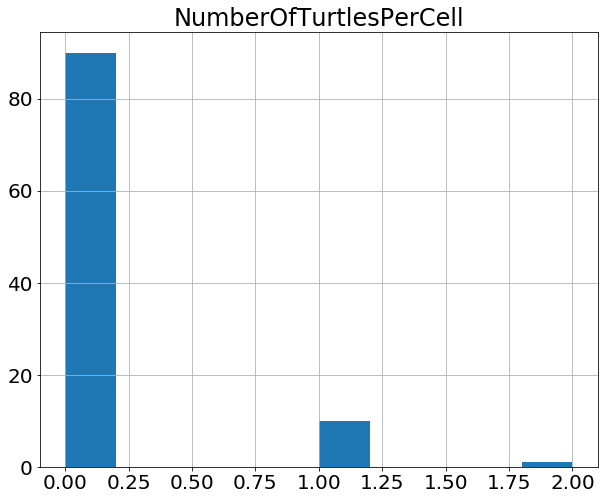

In [14]:
dft.hist("NumberOfTurtlesPerCell")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ba671d0>]],
      dtype=object)

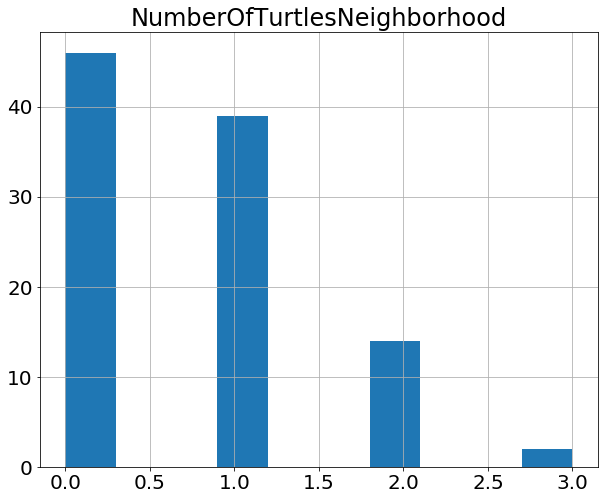

In [15]:
dft.hist("NumberOfTurtlesNeighborhood")